# Plants

## 1) Introduction: 
I found this dataset at: https://archive.ics.uci.edu/dataset/180/plants. It is a plants vs their found locations record. There are over 34k rows and 70 columns. The data was not initially organized for use right away. Some transformation has to be done at the begining. 

Data has been extracted from the USDA plants database. It contains all plants (species and genera) in the database and the states of USA and Canada where they occur. 
The data is in the transactional form. It contains the Latin names (species or genus) and state abbreviations. 

### a) Some package installation for visualization purposes

In [1]:
!pip install wordcloud
!pip install --upgrade pillow

In [2]:
!pip install matplotlib_venn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import NMF

In [4]:
from wordcloud import WordCloud

### b) The dataset was actually giving me problems to open as the first column was the plant names and the rest of the columns represent where they were found. Since a plant can appear in multiple locations, that results in inconsistent amount of columns between plant locations. So I had to take a peek at the first few rows. 

In [5]:
with open('plants.data', 'r', encoding='latin1') as f:
    for _ in range(10):
        print(f.readline())

abelia,fl,nc

abelia x grandiflora,fl,nc

abelmoschus,ct,dc,fl,hi,il,ky,la,md,mi,ms,nc,sc,va,pr,vi

abelmoschus esculentus,ct,dc,fl,il,ky,la,md,mi,ms,nc,sc,va,pr,vi

abelmoschus moschatus,hi,pr

abies,ak,az,ca,co,ct,ga,id,in,ia,me,md,ma,mi,mn,mt,nv,nh,nm,ny,nc,oh,or,pa,ri,tn,ut,vt,va,wa,wv,wi,wy,ab,bc,lb,mb,nb,nf,nt,ns,nu,on,pe,qc,sk,yt,fraspm

abies alba,nc

abies amabilis,ak,ca,or,wa,bc

abies balsamea,ct,in,ia,me,md,ma,mi,mn,nh,ny,oh,pa,ri,vt,va,wv,wi,ab,lb,mb,nb,nf,ns,nu,on,pe,qc,sk,fraspm

abies balsamea var. balsamea,ct,in,ia,me,md,ma,mi,mn,nh,ny,oh,pa,ri,vt,va,wv,wi,ab,lb,mb,nb,nf,ns,nu,on,pe,qc,sk,fraspm



### c) In this case, in order to do modeling, I decided to turn the dataset into a binary matrix with column names being the state abbreviations and row names being the plant names. (0: not found, 1: found).

In [6]:
# Step 1: Start from your lists
plant_names = []
regions = []

with open('plants.data', 'r', encoding='latin1') as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) > 1:
            plant_names.append(parts[0])
            regions.append(parts[1:])

# Step 2: Create DataFrame
df = pd.DataFrame({'plant': plant_names, 'regions': regions})

# Step 3: Expand into binary columns
all_regions = set(r for sublist in df['regions'] for r in sublist)
region_columns = sorted(all_regions)

# Step 4: Initialize binary matrix
binary_matrix = pd.DataFrame(0, index=df.index, columns=region_columns)

for i, region_list in enumerate(df['regions']):
    for region in region_list:
        binary_matrix.at[i, region] = 1

# Step 5: Combine with plant names
pb = pd.concat([df['plant'], binary_matrix], axis=1)
pb

,plant,ab,ak,al,ar,az,bc,ca,co,ct,...,tx,ut,va,vi,vt,wa,wi,wv,wy,yt
0,abelia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,abelia x grandiflora,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,abelmoschus,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
3,abelmoschus esculentus,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
4,abelmoschus moschatus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34776,zuckia brandegeei var. plummeri,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
34777,zygophlebia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34778,zygophlebia sectifrons,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34779,zygophyllum,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,1,0,0,0,0


## 2) EDA

### a) To find any duplicate of the plant species, I used .unique() for a quick check. The result turned out to be the same length of the original data length which indicates no duplication. 

In [7]:
cat = pb['plant'].unique()
len(cat)

34781

### b) Next, I am curious to know if there is any all 0 column or row which indicates either a plant was not found in any location or a location has found no plant at all. And the results are both none.

In [8]:
all_zero_columns = pb.eq(0).all()
# Get names of all-zero columns
all_zero_columns[all_zero_columns].index.tolist() 

[]

In [9]:
all_zero_rows = pb.eq(0).all(axis=1)
# Get names of all-zero columns
all_zero_rows[all_zero_rows].index.tolist() 

[]

In [10]:
X = pb.drop('plant', axis=1)

## 3) Visualizations

### a) Heat map of different plants and their found locations

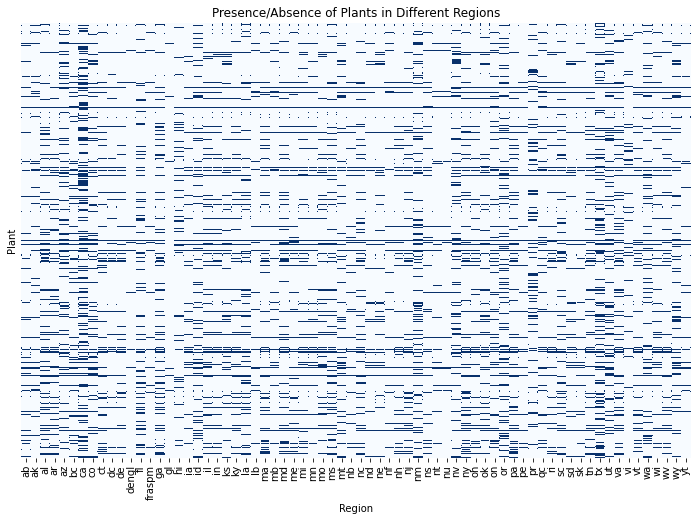

In [11]:
# Visualize the binary matrix as a heatmap
plt.figure(figsize=(12, 8))  # Adjust size based on your data
sns.heatmap(X, cmap='Blues', cbar=False, xticklabels=True, yticklabels=False)

# Add labels
plt.title('Presence/Absence of Plants in Different Regions')
plt.xlabel('Region')
plt.ylabel('Plant')

plt.show()

### b) Max number of plants found in all states

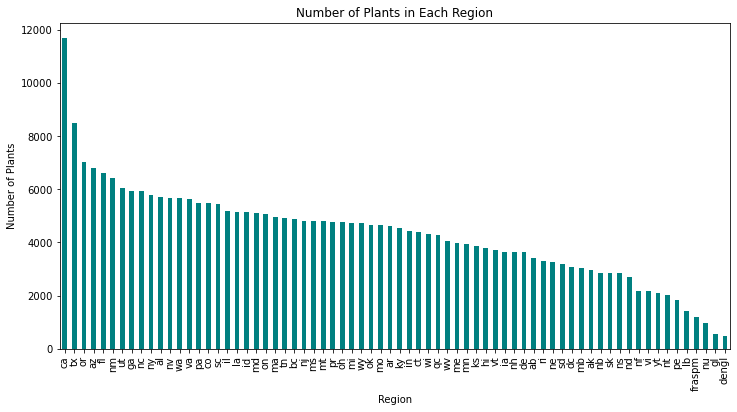

In [12]:
# Sum up the presence of plants in each region
region_counts = X.sum()

# Plot the bar chart
plt.figure(figsize=(12, 6))
region_counts.sort_values(ascending=False).plot(kind='bar', color='teal')

plt.title('Number of Plants in Each Region')
plt.xlabel('Region')
plt.ylabel('Number of Plants')
plt.xticks(rotation=90)
plt.show()

### c) Shared number of plants among 3 selected states

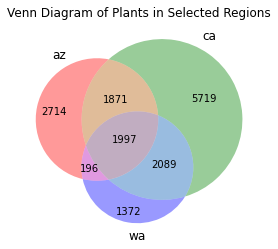

In [13]:
# Example: Select a subset of 3 regions to compare
selected_regions = ['az', 'ca', 'wa']  # Replace with actual region names
subset_df = pb[selected_regions]

# Convert to a set of plants in each region
set1 = set(pb.loc[subset_df[selected_regions[0]] == 1, 'plant'])
set2 = set(pb.loc[subset_df[selected_regions[1]] == 1, 'plant'])
set3 = set(pb.loc[subset_df[selected_regions[2]] == 1, 'plant'])

# Create Venn diagram
venn3([set1, set2, set3], set_labels=selected_regions)
plt.title('Venn Diagram of Plants in Selected Regions')
plt.show()

### d) Most frequent found plants across all states

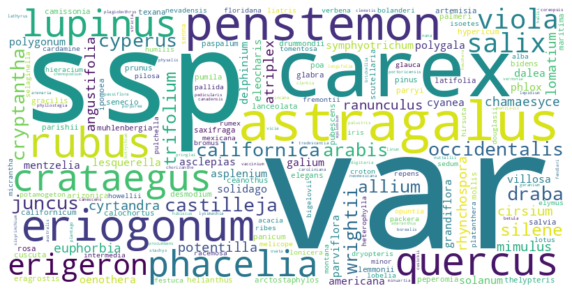

In [14]:
# Generate word cloud based on plant names
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(pb['plant']))

# Plot word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 4) Modeling

#### a) First we do a scaling for better accuracy

In [15]:
X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[-0.32958829, -0.30549887, -0.44281658, ..., -0.36363562,
        -0.39576421, -0.25349067],
       [-0.32958829, -0.30549887, -0.44281658, ..., -0.36363562,
        -0.39576421, -0.25349067],
       [-0.32958829, -0.30549887, -0.44281658, ..., -0.36363562,
        -0.39576421, -0.25349067],
       ...,
       [-0.32958829, -0.30549887, -0.44281658, ..., -0.36363562,
        -0.39576421, -0.25349067],
       [-0.32958829, -0.30549887, -0.44281658, ..., -0.36363562,
        -0.39576421, -0.25349067],
       [-0.32958829, -0.30549887, -0.44281658, ..., -0.36363562,
        -0.39576421, -0.25349067]])

### b) Next, let's reduce the number of features using pca.

In [16]:
pca = PCA(n_components=2).fit(X_scaled)
pca_reduced = pca.fit_transform(X_scaled)

In [46]:
pca_reduced

array([[-2.36335362, -0.99644654],
       [-2.36335362, -0.99644654],
       [ 1.74343362, -4.56687835],
       ...,
       [-2.90217882, -0.35873899],
       [-0.16772304,  1.88073555],
       [-0.16772304,  1.88073555]])

### c) Let's build a kmeans model
####  Let's define the number of clusters using the elbow method

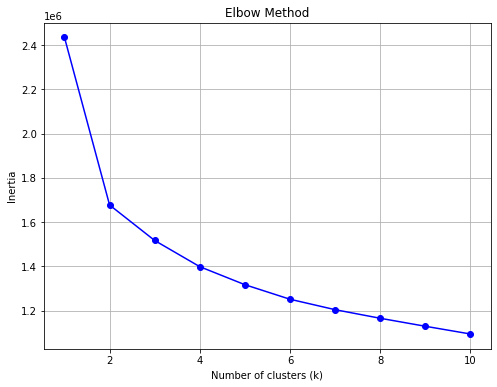

In [49]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, 'o-', color='blue')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

#### It's clear that before 2 clusters, the inertia drops quickly and then slowly fades away. So we are going for 2 clusters. 
#### Now let's fit the model and predict the cluster labels. 

In [73]:
kmeans = KMeans(2).fit(X_scaled)
clusters = kmeans.fit_predict(X_scaled)
clusters[:10] # first 10 cluster labels

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 1], dtype=int32)

#### Let's visualize the result with reduced features by pca

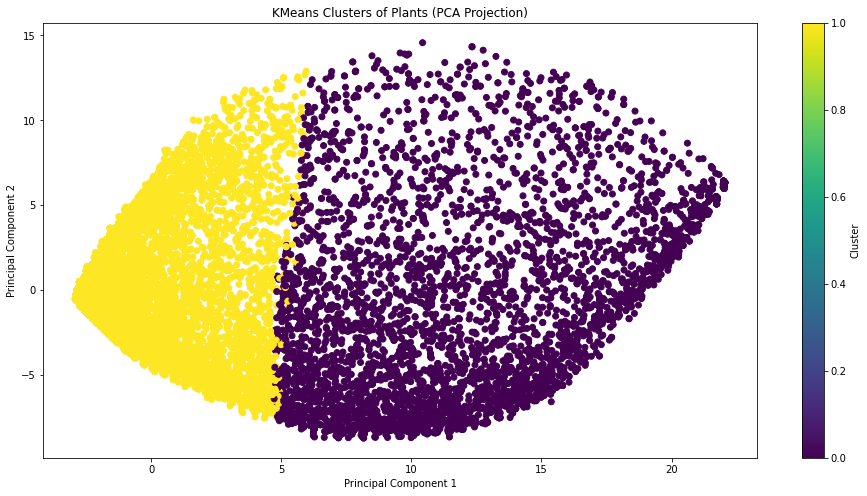

In [66]:
plt.figure(figsize=(16, 8))

# 4. Plot PCA results with cluster colors
plt.scatter(pca_reduced[:, 0], pca_reduced[:, 1], c=clusters, cmap='viridis')
plt.title('KMeans Clusters of Plants (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

### c) How about a hierarchical clustering model? I selected first 3000 samples as the whole dataset will lead to a dead kernel while running.

#### Let's still use 2 clusters.

In [77]:
agglo = AgglomerativeClustering(n_clusters=2, linkage='ward')
clusters_h = agglo.fit_predict(X_scaled[:3000])

#### Let's compare the result between kmeans and hierarchical

In [85]:
pd.crosstab(clusters[:3000], clusters_h)

col_0,0,1
row_0,,
0,2543,33
1,72,352


#### Looks like they performed quite similar

In [86]:
agreement = (2543 + 352) / (2543 + 33 + 72 + 352)
print(f"Agreement rate: {agreement:.2%}")

Agreement rate: 96.50%


#### For visualization with reduced pca method, fit the sampled data with pca too

In [88]:
pca_hier = PCA(n_components=2).fit(X_hier_scaled)
pca_hier_reduced = pca_hier.fit_transform(X_hier_scaled)

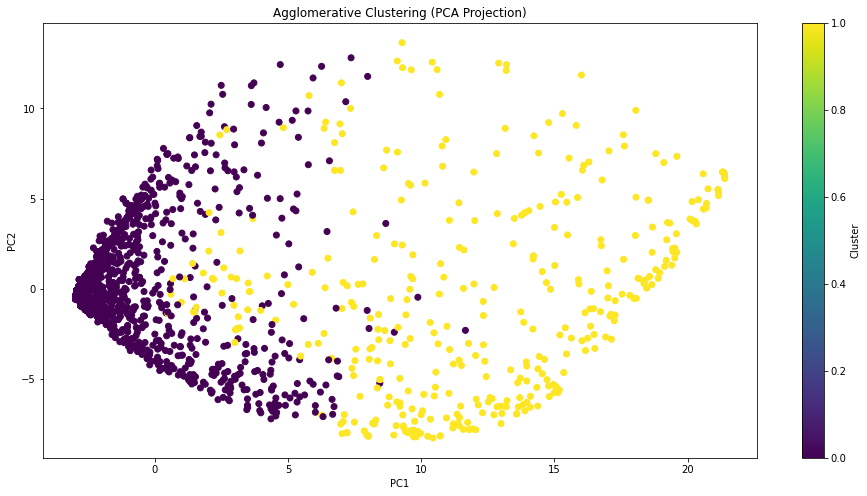

In [89]:
plt.figure(figsize=(16, 8))

# 4. Plot PCA results with cluster colors
plt.scatter(pca_hier_reduced[:, 0], pca_hier_reduced[:, 1], c=clusters_hier, cmap='viridis')
plt.title('Agglomerative Clustering (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

### d) How about a matrix factorization model: nmf?

In [101]:
nmf = NMF(n_components=2)
W = nmf.fit_transform(X)
H = nmf.components_

In [92]:
W

array([[0.0188869 , 0.        ],
       [0.0188869 , 0.        ],
       [0.11684334, 0.        ],
       ...,
       [0.00223448, 0.        ],
       [0.01616928, 0.12674828],
       [0.01616928, 0.12674828]])

In [93]:
clusters_n = np.argmax(W, axis=1)

#### Wow! The result is so much different than the other two.

In [97]:
pd.crosstab(clusters_h, clusters_n[:3000])

col_0,0,1
row_0,,
0,1007,1608
1,286,99


## Comparision and Conclusion

### After the comparison, 
#### between kmeans and hierarchical: 99.6% similarity
#### kmeans and nmf: 36%

Likely reason: mmf groups plants based on co-occurrence of presence in region groups, rather than distance or density.
For example: NMF might create a cluster for “tropical region plants” even if those plants are far apart in Euclidean space.